In [47]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import io
import re
import string
import tqdm
import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Loading and cleaning dataset

In [8]:
df = pd.read_csv("./data/text_emotion.csv")
cleaned_df = df.copy()

In [9]:
# remove mentions, hashtags and links
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: re.sub("@[A-Za-z0-9_]+","", sentence))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: re.sub(r"http\S+", "", sentence))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: re.sub(r"http\S+", "", sentence))

# removing stopwords
stop_words = set(stopwords.words('english'))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([word for word in sentence.split() if word not in stop_words]))

# removing all punctuation marks
exclude = set(string.punctuation)
regex = re.compile('[%s]' % re.escape(string.punctuation))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: regex.sub("",sentence))

# lowercasing 'content' column
cleaned_df['content'] = cleaned_df['content'].str.lower()

# removing unicode characters
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: sentence.encode("ascii","ignore").decode())

# Preprocess data

In [20]:
max_sentence_len = cleaned_df['content'].apply(lambda s: len(s.split())).max() + 1

In [10]:
EMBEDDING_DIM = 50

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(cleaned_df['content']))
sequences = tokenizer.texts_to_sequences(list(cleaned_df['content']))

# pad sequences
word_index = tokenizer.word_index
print('Unique tokens: {}'.format(len(word_index)))

content_pad = pad_sequences(sequences, maxlen=EMBEDDING_DIM)
num_words = len(word_index) + 1

Unique tokens: 35736


# Get glove embeddings

In [15]:
def load_pretrained_embedding(embedding_fpath):
    #loads embeddings from file e.g GloVe to a dict object
    with open(embedding_fpath, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            words.add(line[0])
            word_to_vec_map[line[0]] = np.array(line[1:], dtype=np.float64)
            
        return word_to_vec_map

In [16]:
word_to_vec_map = load_pretrained_embedding('./data/glove.twitter.27B.50d.txt')

In [17]:
def get_embedding_weights(word_to_vec_map, vocab_len, word_index):
    #function to get GloVe embedding weights
    emb_dim = word_to_vec_map["the"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    unks = []
    unk_count = 0
    
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_index.items():
        emb = word_to_vec_map.get(word)
        if emb is not None:
            emb_matrix[idx] = emb
        else:
            emb_matrix[idx] = word_to_vec_map.get('unk') #get the 'unk' embedding from glove for OOV
            unk_count = unk_count + 1
            unks.append(word)
            
    return emb_matrix, unks

In [18]:
#get the embedding matrix weights
embedding_matrix_wgt, unks = get_embedding_weights(word_to_vec_map, num_words, word_index)

# Build model

In [19]:
# callback to save the best weights for the model
def saveWeightsCallback(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor = monitor,
        verbose = 1,
        save_best_only = True,
        save_weights_only = True,
        mode = mode,
        save_freq=save_freq,
)

In [55]:
def build_model(embedding_dim,max_length):
    model = keras.models.Sequential()
    model.add(layers.Embedding(input_dim=num_words,
                               output_dim=embedding_dim))
    model.add(layers.Bidirectional(
        layers.LSTM(units=64,return_sequences=True)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Bidirectional(
        layers.LSTM(units=64)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(13,activation='softmax'))
    return model

In [56]:
LSTM_model = build_model(EMBEDDING_DIM,EMBEDDING_DIM)

LSTM_model.layers[0].set_weights([embedding_matrix_wgt])
LSTM_model.layers[0].trainable = False

LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          1786850   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        58880     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 13)               

In [57]:
LSTM_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

In [58]:
y = pd.get_dummies(df['sentiment']).values
print('x shape: {}'.format(content_pad.shape))
print('y shape: {}'.format(y.shape))

x shape: (40000, 50)
y shape: (40000, 13)


In [59]:
x_train, x_test, y_train, y_test = train_test_split(content_pad, y, test_size = 0.30, random_state = 42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(28000, 50) (28000, 13)
(12000, 50) (12000, 13)


In [60]:
history = LSTM_model.fit(x_train,
                        y_train,
                        batch_size=128,
                        epochs = 25,
                        verbose=2,
                        validation_data = (x_test,y_test))

callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                     saveWeightsCallback(
                         path='./weights/LSTM',
                         monitor = 'val_loss',
                         mode = 'min',
                         save_freq='epoch',
                     )],      

Epoch 1/25
219/219 - 34s - loss: 2.2314 - accuracy: 0.2423 - val_loss: 2.0987 - val_accuracy: 0.2707 - 34s/epoch - 155ms/step
Epoch 2/25
219/219 - 24s - loss: 2.0579 - accuracy: 0.2907 - val_loss: 2.0136 - val_accuracy: 0.3073 - 24s/epoch - 111ms/step
Epoch 3/25
219/219 - 25s - loss: 2.0090 - accuracy: 0.3057 - val_loss: 1.9870 - val_accuracy: 0.3198 - 25s/epoch - 113ms/step
Epoch 4/25
219/219 - 25s - loss: 1.9886 - accuracy: 0.3139 - val_loss: 1.9730 - val_accuracy: 0.3254 - 25s/epoch - 113ms/step
Epoch 5/25
219/219 - 24s - loss: 1.9725 - accuracy: 0.3214 - val_loss: 1.9603 - val_accuracy: 0.3319 - 24s/epoch - 111ms/step
Epoch 6/25
219/219 - 24s - loss: 1.9574 - accuracy: 0.3270 - val_loss: 1.9463 - val_accuracy: 0.3347 - 24s/epoch - 111ms/step
Epoch 7/25
219/219 - 24s - loss: 1.9496 - accuracy: 0.3296 - val_loss: 1.9390 - val_accuracy: 0.3378 - 24s/epoch - 110ms/step
Epoch 8/25
219/219 - 23s - loss: 1.9415 - accuracy: 0.3329 - val_loss: 1.9323 - val_accuracy: 0.3397 - 23s/epoch - 106

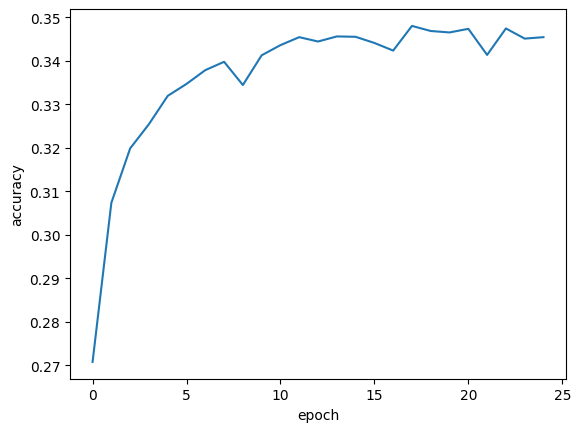

In [61]:
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

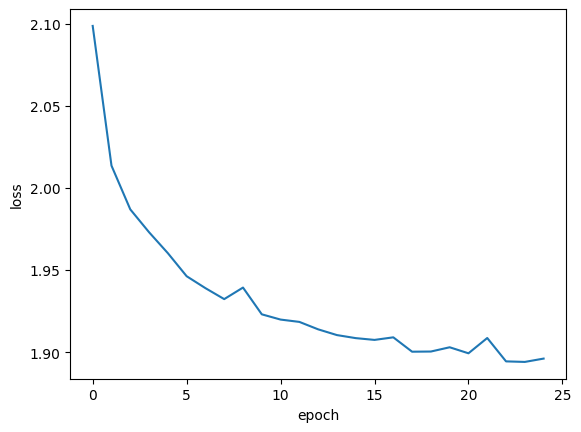

In [62]:
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()